# SparkR example #

This notebook demonstrates basic use of SparkR library on Apache Spark. Documentation  about SparkR can be found from http://spark.apache.org/docs/latest/sparkr.html

First, import needed libraries and initialize sparkR session

In [1]:
library(SparkR) # mandatory library for R
library(ggplot2)

sparkR.session()

Warning message:
“package ‘SparkR’ was built under R version 3.4.4”
Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union

Spark package found in SPARK_HOME: /usr/local/spark


Launching java with spark-submit command /usr/local/spark/bin/spark-submit   sparkr-shell /tmp/RtmpgLHy0d/backend_port12462610c1f9 


Java ref type org.apache.spark.sql.SparkSession id 1 

Read .csv files to SparkR DataFrame. SparkR dataframes are similar to R data.frame but some concepts like lazy evaluation comes from Spark world.
Unlike PySpark and Scala, R doesn't support RDD so only higher level abstractions like DataFrame are available.

In [2]:
titanic_data_df <- read.df("data/Titanic_data.csv", 
                        header='true', 
                        source = "csv", 
                        inferSchema='true')

In [3]:
titanic_names_df <- read.df("data/Titanic_names.csv", 
                    header='true',
                    source = "csv",
                    inferSchema='true')

## Data Exploration

Some data exploration to understand what kind of data we are working with

In [4]:
printSchema(titanic_data_df)

root
 |-- id: integer (nullable = true)
 |-- PClass: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- GenderCode: integer (nullable = true)


In [5]:
head(titanic_data_df)
head(titanic_names_df)

id,PClass,Age,Gender,Survived,GenderCode
1,1st,29.00,female,1,1
2,1st,2.00,female,0,1
3,1st,30.00,male,0,0
4,1st,25.00,female,0,1
5,1st,0.92,male,1,0
6,1st,47.00,male,1,0


id,Name
1,"Allen, Miss Elisabeth Walton"
2,"Allison, Miss Helen Loraine"
3,"Allison, Mr Hudson Joshua Creighton"
4,"Allison, Mrs Hudson JC (Bessie Waldo Daniels)"
5,"Allison, Master Hudson Trevor"
6,"Anderson, Mr Harry"


You can count the rows using either nrow() or count() functions. To read more about those functions, use ?nrow or ?count commands in cell below.

In [6]:
?nrow

In [7]:
nrow(titanic_data_df)
count(titanic_names_df)

[1] 1313

[1] 1313

In [8]:
# To transform Spark DataFrame to R data.frame use R "<-" syntax
titanic_rows <- nrow(titanic_data_df)
print(titanic_rows)

[1] 1313


In [9]:
titanic_data_summary <- describe(titanic_data_df)

In [10]:
collect(titanic_data_summary)

summary,id,PClass,Age,Gender,Survived,GenderCode
count,1313,1313,1313,1313,1313,1313
mean,657.0,NA,17.502574257425742,NA,0.3427265803503427,0.3518659558263519
stddev,379.1747618183468,NA,18.51694476332819,NA,0.47480181908910607,0.47773437008438874
min,1,*,0.0,female,0,0
max,1313,3rd,71.0,male,1,1


Age 0.0 seems weird. Are there many of those?


In [11]:
nrow(filter(select(titanic_data_df,"*"), "Age == 0.0"))

[1] 557

Quite many, let's remove those lines

In [12]:
# Filter Ages over 0.0 only to new dataframe (with same name)
titanic_data_df <- filter(select(titanic_data_df,"*"), "Age > 0.0")

In [13]:
# Check out how many rows we have left after removing Age 0.0 lines. Should be 1313-557=756
nrow(titanic_data_df)

[1] 756

## Plotting

To plot data you have to collect data from Spark DataFrame to R data.frame.
Let's demonstrate plotting with ggplot using Survived -column data.

In [14]:
titanic_data_survival <- collect(select(titanic_data_df,"Survived"))

In [15]:
# Check the structure of titanic_data_survival to see data type, amount and small sample of rows
str(titanic_data_survival)

'data.frame':	756 obs. of  1 variable:
 $ Survived: int  1 0 0 0 1 1 1 0 1 0 ...


In [16]:
titanic_data_survival$Survived <- factor(
    x=titanic_data_survival$Survived, 
    levels=c(0,1),
    labels=c('Not survived', 'Survived')
)

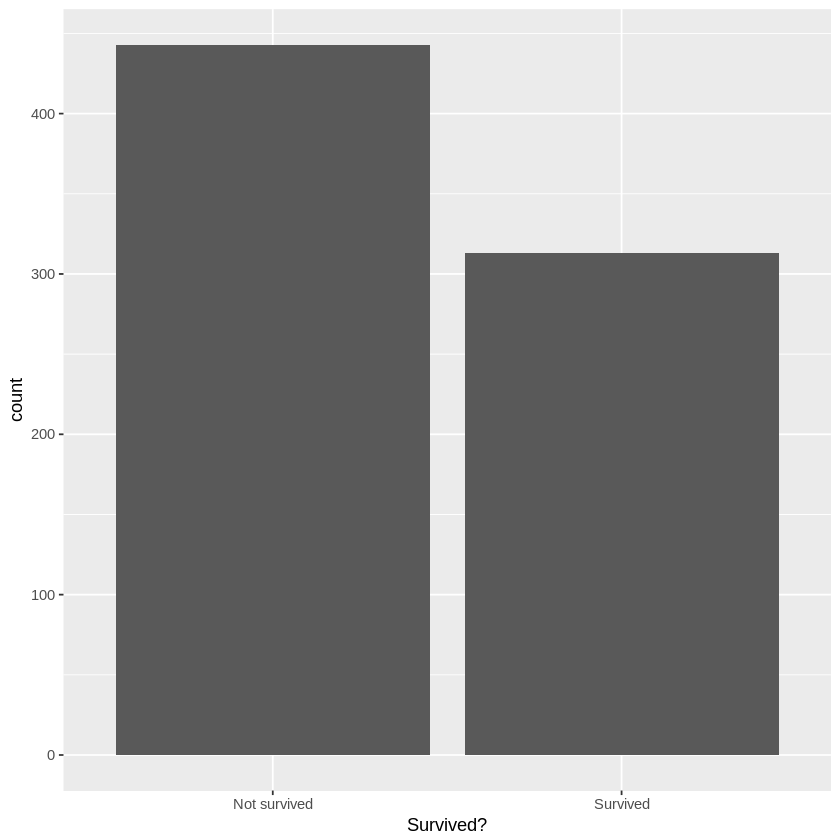

In [17]:
c <- ggplot(data=titanic_data_survival, aes(x=factor(Survived)))
c + geom_bar() + xlab("Survived?")

Data can be selected using R-syntax dataframe_name$column, but for more complex operations the SQL-syntax from SparkSQL library can be used with selectExpr() function. 

In [18]:
head(select(titanic_data_df, titanic_data_df$Age))

Age
29.00
2.00
30.00
25.00
0.92
47.00


In [19]:
head(selectExpr(titanic_data_df, "AGE * 12 AS Age_in_months"))

Age_in_months
348.00
24.00
360.00
300.00
11.04
564.00


In [20]:
# Filtering and counting only female survivors
female_survivors <- filter(select(titanic_data_df, "*"), "Survived == 1 AND Gender == 'female'")
nrow(female_survivors)

[1] 217

In [21]:
collect(female_survivors)

id,PClass,Age,Gender,Survived,GenderCode
1,1st,29,female,1,1
7,1st,63,female,1,1
9,1st,58,female,1,1
12,1st,19,female,1,1
16,1st,50,female,1,1
20,1st,47,female,1,1
24,1st,19,female,1,1
28,1st,30,female,1,1
29,1st,58,female,1,1
31,1st,45,female,1,1


If you like to use SQL queries, you can transform DataFrame to SQL table and use full SQL clauses to filter and collect data to R data.frame 

First create temporary SQL table 

Use SQL against it

Transform it to R data.frame for manipulating data with R commands


In [22]:
createOrReplaceTempView(titanic_data_df, "titanic_data")

In [23]:
male_under_50 <- collect(sql("SELECT * FROM titanic_data WHERE Gender == 'male' AND Age < 50 AND Survived == 1"))
nrow(male_under_50)

[1] 91

In [24]:
male_under_50

id,PClass,Age,Gender,Survived,GenderCode
5,1st,0.92,male,1,0
6,1st,47.00,male,1,0
19,1st,37.00,male,1,0
21,1st,26.00,male,1,0
23,1st,25.00,male,1,0
25,1st,28.00,male,1,0
27,1st,39.00,male,1,0
44,1st,36.00,male,1,0
48,1st,36.00,male,1,0
51,1st,11.00,male,1,0


## Aggregating and sorting

In [25]:
# Group passengers by different Passenger Class and count amount of people in each  
titanic_pclass <- collect(agg(groupBy(titanic_data_df, "PClass"),
                             Amount=n(titanic_data_df$PClass)
                             ))
titanic_pclass

PClass,Amount
2nd,212
1st,226
3rd,318


In [26]:
# Aggregating, joining and sorting using SQL syntax to get overview about people and survivals of each class
class_counts <- sql("SELECT PClass, COUNT(PClass) AS PClass_count FROM titanic_data GROUP BY pclass")
collect(class_counts)

PClass,PClass_count
2nd,212
1st,226
3rd,318


In [27]:
class_survivors <- sql("SELECT PClass, COUNT(PClass) AS PClass_survivors FROM titanic_data WHERE Survived == 1 GROUP BY PClass")
collect(class_survivors)

PClass,PClass_survivors
2nd,96
1st,139
3rd,78


In [28]:
# Double PClass should be cleaned
joined_counts <- join(class_counts,class_survivors, class_counts$PClass == class_survivors$PClass)
collect(joined_counts)

PClass,PClass_count,PClass,PClass_survivors
2nd,212,2nd,96
1st,226,1st,139
3rd,318,3rd,78


Plotting to visualize differences in survival ratios between classes

Other joining example: Mapping names to the list of survived female

In [29]:
# Double ID's should be removed
females_with_names <- join(female_survivors, titanic_names_df, female_survivors$id == titanic_names_df$id)

In [30]:
collect(females_with_names)

id,PClass,Age,Gender,Survived,GenderCode,id,Name
1,1st,29,female,1,1,1,"Allen, Miss Elisabeth Walton"
7,1st,63,female,1,1,7,"Andrews, Miss Kornelia Theodosia"
9,1st,58,female,1,1,9,"Appleton, Mrs Edward Dale (Charlotte Lamson)"
12,1st,19,female,1,1,12,"Astor, Mrs John Jacob (Madeleine Talmadge Force)"
16,1st,50,female,1,1,16,"Baxter, Mrs James (Helene DeLaudeniere Chaput)"
20,1st,47,female,1,1,20,"Beckwith, Mrs Richard Leonard (Sallie Monypeny)"
24,1st,19,female,1,1,24,"Bishop, Mrs Dickinson H (Helen Walton)"
28,1st,30,female,1,1,28,"Bonnell, Miss Caroline"
29,1st,58,female,1,1,29,"Bonnell, Miss Elizabeth"
31,1st,45,female,1,1,31,"Bowen, Miss Grace Scott"
